<a href="https://colab.research.google.com/github/paolala24/aprendizaje_maquinas/blob/main/talleres/6_CVClasificacion_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [1]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


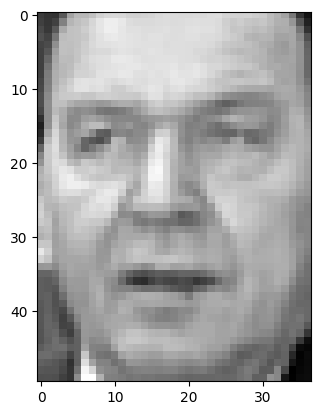

In [2]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [3]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [4]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [ ]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


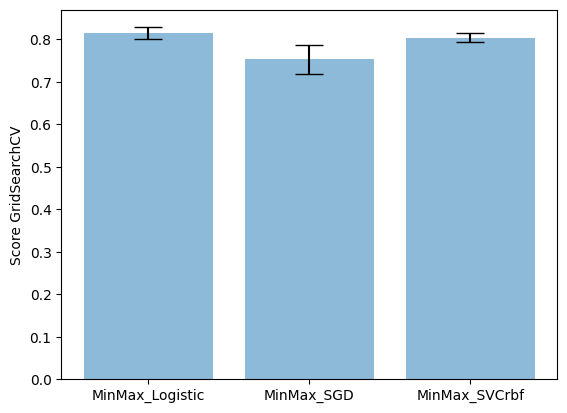

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.752 0.804]
 [0.014 0.034 0.011]]


In [6]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

Evaluando modelo MinMax_Logistic (1/3)


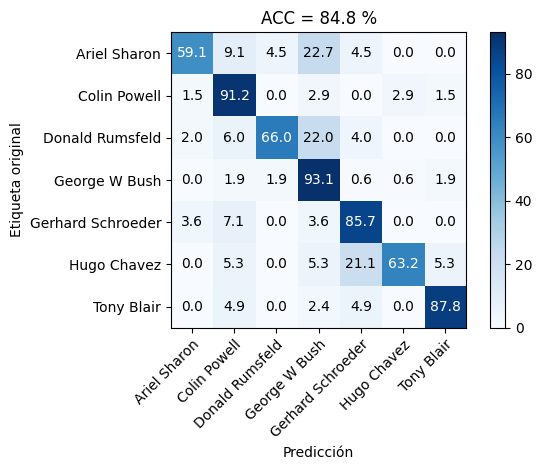

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


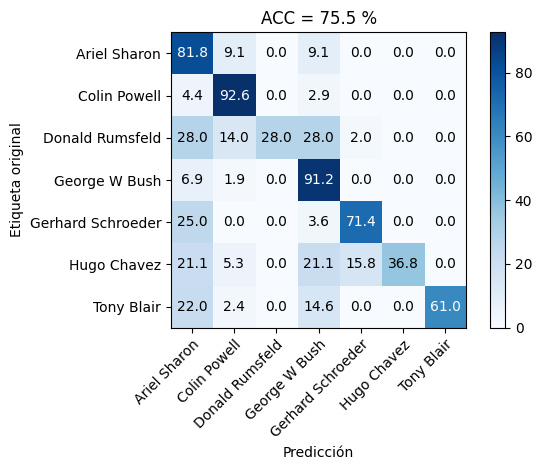

                   precision    recall  f1-score   support

     Ariel Sharon       0.27      0.82      0.41        22
     Colin Powell       0.82      0.93      0.87        68
  Donald Rumsfeld       1.00      0.28      0.44        50
    George W Bush       0.83      0.91      0.87       159
Gerhard Schroeder       0.83      0.71      0.77        28
      Hugo Chavez       1.00      0.37      0.54        19
       Tony Blair       1.00      0.61      0.76        41

         accuracy                           0.75       387
        macro avg       0.82      0.66      0.66       387
     weighted avg       0.85      0.75      0.75       387

Evaluando modelo MinMax_SVCrbf (3/3)


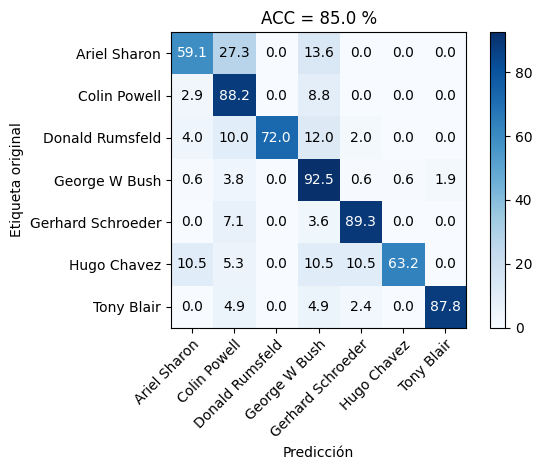

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [7]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/3)


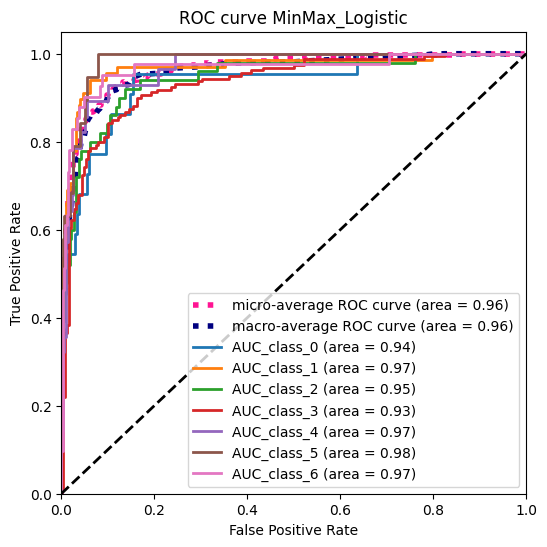

Evaluando modelo MinMax_SGD (2/3)


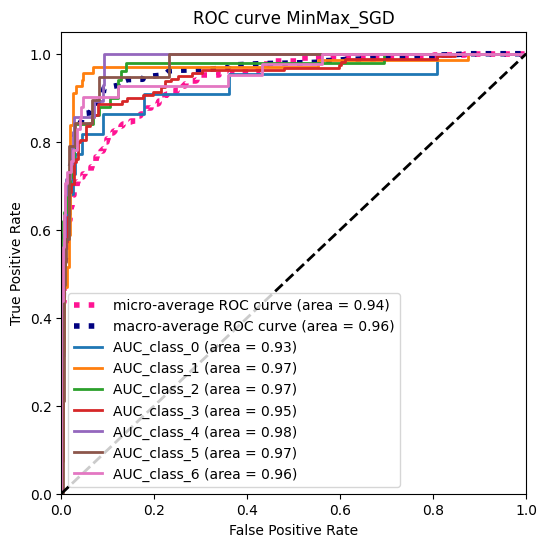

Evaluando modelo MinMax_SVCrbf (3/3)


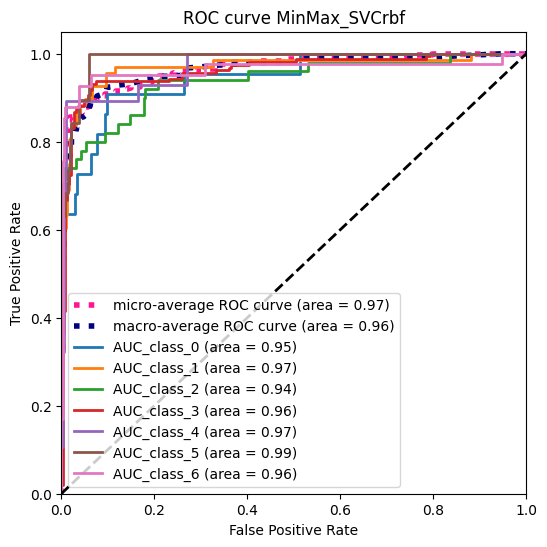

In [8]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1. Emplee optimización Bayesiana de hiperparámetros, fijando el score en términos del acc, el f1 y el AUC.


#PARTE 1: Modelo y problema de optimización de cada clasificador

# 📌 Modelos y problemas de optimización de clasificadores

A continuación se describe el modelo y el problema de optimización para cada uno de los clasificadores considerados:

---

### 🔹 1. `Naive_Bayes.GaussianNB`
- **Modelo**: Clasificador probabilístico que asume independencia entre características y que cada clase sigue una distribución normal.
- **Optimización**: No tiene un problema de optimización. Estima media y varianza de cada clase y aplica la regla de Bayes:
  $$
  \hat{y} = \arg\max_{c} \; P(y=c) \prod_{i} P(x_i \mid y=c)
  $$

---

### 🔹 2. `SGDClassifier`
- **Modelo**: Clasificación mediante descenso de gradiente estocástico.
- **Optimización**:
  $$
  \min_w \; \frac{1}{n} \sum_{i=1}^n \ell(w; x_i, y_i) + \alpha R(w)
  $$
  donde:
  - $\ell$: pérdida (ej. `hinge`, `log_loss`)
  - $R(w)$: regularización \(L_1\), \(L_2\)
  - $\alpha\$: peso de la regularización

---

### 🔹 3. `LogisticRegression`
- **Modelo**: Clasificador lineal con función sigmoide para probabilidades.
- **Optimización**:
  $$
  \min_w \; -\sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] + \lambda \|w\|^2
  $$
  donde $\hat{y}_i = \frac{1}{1 + e^{-w^T x_i}}$ y $\lambda = 1/C$

---

### 🔹 4. `LinearDiscriminantAnalysis (LDA)`
- **Modelo**: Encuentra una proyección que maximiza la separabilidad entre clases.
- **Optimización**:
  $$
  \max_w \; \frac{w^T S_B w}{w^T S_W w}
  $$
  donde $S_B$ es la varianza entre clases y $S_W$ dentro de clases.

---

### 🔹 5. `KNeighborsClassifier`
- **Modelo**: Clasifica según la mayoría de los $k$ vecinos más cercanos.
- **Optimización**: No hay optimización interna, pero se deben elegir:
  - $k$: número de vecinos
  - Métrica: distancia Euclidiana, Manhattan, etc.

---

### 🔹 6. `LinearSVC`
- **Modelo**: Máquina de vectores de soporte lineal.
- **Optimización**:
  $$
  \min_{w, b} \; \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \max(0, 1 - y_i(w^T x_i + b))^2
  $$
  Se maximiza el margen penalizando errores.

---

### 🔹 7. `SVC`
- **Modelo**: SVM con soporte para kernels no lineales.
- **Optimización**:
  $$
  \min_{w,b,\xi} \; \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \xi_i
  \quad \text{s.a. } y_i(w^T \phi(x_i) + b) \geq 1 - \xi_i
  $$
  donde $\phi(x)$ es el espacio transformado por el kernel.

---

### 🔹 8. `RandomForestClassifier`
- **Modelo**: Ensamble de árboles de decisión (bagging).
- **Optimización**:
  - Cada árbol minimiza la **impureza** (Gini o entropía) en cada división.
  - Hiperparámetros como número de árboles, profundidad, etc., afectan el resultado global.


In [9]:
# Instalación necesaria para optimización bayesiana
!pip install scikit-optimize

# Librerías
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
from skopt import BayesSearchCV
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [10]:
# Cargar librerías
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar clasificadores
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

# Mostrar modelos y descripción
modelos = {
    "GaussianNB": "Naive Bayes Gaussiano: Probabilístico, asume independencia y distribución normal.",
    "SGDClassifier": "Stochastic Gradient Descent: Optimización de pérdida (e.g. hinge o log) por descenso estocástico.",
    "LogisticRegression": "Regresión logística: Modela la probabilidad de clase usando la función sigmoide.",
    "LinearDiscriminantAnalysis": "Análisis discriminante lineal: Proyección lineal que maximiza separabilidad entre clases.",
    "KNeighborsClassifier": "K-NN: Clasificación basada en los k vecinos más cercanos en el espacio.",
    "LinearSVC": "SVM Lineal: Maximiza el margen entre clases, resolución mediante optimización convexa.",
    "SVC": "SVM Kernel: Como LinearSVC pero con núcleo (por defecto RBF).",
    "RandomForestClassifier": "Bosque aleatorio: Ensamble de árboles entrenados con aleatoriedad en datos y atributos."
}

for nombre, desc in modelos.items():
    print(f"🔹 {nombre}:\n  {desc}\n")


🔹 GaussianNB:
  Naive Bayes Gaussiano: Probabilístico, asume independencia y distribución normal.

🔹 SGDClassifier:
  Stochastic Gradient Descent: Optimización de pérdida (e.g. hinge o log) por descenso estocástico.

🔹 LogisticRegression:
  Regresión logística: Modela la probabilidad de clase usando la función sigmoide.

🔹 LinearDiscriminantAnalysis:
  Análisis discriminante lineal: Proyección lineal que maximiza separabilidad entre clases.

🔹 KNeighborsClassifier:
  K-NN: Clasificación basada en los k vecinos más cercanos en el espacio.

🔹 LinearSVC:
  SVM Lineal: Maximiza el margen entre clases, resolución mediante optimización convexa.

🔹 SVC:
  SVM Kernel: Como LinearSVC pero con núcleo (por defecto RBF).

🔹 RandomForestClassifier:
  Bosque aleatorio: Ensamble de árboles entrenados con aleatoriedad en datos y atributos.



In [12]:
# Librerías necesarias
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import warnings
warnings.filterwarnings('ignore')

# Cargar dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Normalización
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Definir clasificadores y espacios de búsqueda
clasificadores = {
    'GaussianNB': (GaussianNB(), {}),

    'SGDClassifier': (
        SGDClassifier(max_iter=1000, tol=1e-3),
        {
            'alpha': Real(1e-6, 1e-2, prior='log-uniform'),
            'penalty': Categorical(['l2', 'l1']),
            'loss': Categorical(['hinge', 'log_loss'])
        }
    ),

    'LogisticRegression': (
        LogisticRegression(max_iter=1000),
        {
            'C': Real(1e-4, 1e2, prior='log-uniform'),
            'penalty': Categorical(['l2']),
            'solver': Categorical(['liblinear', 'lbfgs'])
        }
    ),

    'LinearDiscriminantAnalysis': (LinearDiscriminantAnalysis(), {}),

    'KNeighborsClassifier': (
        KNeighborsClassifier(),
        {
            'n_neighbors': Integer(1, 20),
            'weights': Categorical(['uniform', 'distance'])
        }
    ),

    'LinearSVC': (
        LinearSVC(max_iter=10000),
        {
            'C': Real(1e-4, 10, prior='log-uniform'),
            'loss': Categorical(['hinge', 'squared_hinge'])
        }
    ),

    'SVC': (
        SVC(probability=True),
        {
            'C': Real(1e-3, 10, prior='log-uniform'),
            'kernel': Categorical(['linear', 'rbf', 'poly']),
            'gamma': Real(1e-4, 1.0, prior='log-uniform')
        }
    ),

    'RandomForestClassifier': (
        RandomForestClassifier(),
        {
            'n_estimators': Integer(50, 200),
            'max_depth': Integer(2, 20),
            'max_features': Categorical(['sqrt', 'log2', None])
        }
    )
}

# Métricas a evaluar
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'AUC': make_scorer(roc_auc_score)
}

# Evaluar cada modelo
resultados = []

for nombre, (modelo, espacio) in clasificadores.items():
    print(f"🔍 Optimizando {nombre}...")
    for score_nombre, scorer in scorers.items():
        if espacio:
            search = BayesSearchCV(
                modelo, espacio,
                n_iter=20, cv=5,
                scoring=scorer,
                random_state=42,
                n_jobs=-1
            )
        else:
            search = modelo

        if espacio:
            search.fit(X, y)
            mejor_score = search.best_score_
        else:
            scores = cross_val_score(search, X, y, cv=5, scoring=scorer)
            mejor_score = np.mean(scores)

        resultados.append({
            'Modelo': nombre,
            'Métrica': score_nombre,
            'Score': mejor_score
        })

# Mostrar resultados
df_resultados = pd.DataFrame(resultados)
df_pivot = df_resultados.pivot(index='Modelo', columns='Métrica', values='Score')
df_pivot = df_pivot.sort_values(by='accuracy', ascending=False)
df_pivot


🔍 Optimizando GaussianNB...
🔍 Optimizando SGDClassifier...
🔍 Optimizando LogisticRegression...
🔍 Optimizando LinearDiscriminantAnalysis...
🔍 Optimizando KNeighborsClassifier...
🔍 Optimizando LinearSVC...
🔍 Optimizando SVC...
🔍 Optimizando RandomForestClassifier...


Métrica,AUC,accuracy,f1
Modelo,,,
LogisticRegression,0.980757,0.984195,0.987509
LinearSVC,0.976051,0.980686,0.984807
SGDClassifier,0.976496,0.980686,0.986109
SVC,0.975560,0.978916,0.984727
KNeighborsClassifier,0.964283,0.968390,0.975357
RandomForestClassifier,0.959235,0.964912,0.972295
LinearDiscriminantAnalysis,0.947626,0.959587,0.968663
GaussianNB,0.921601,0.927930,0.942594
